In [146]:
import torch
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.core.display import display, HTML
from bertviz import head_view, model_view

from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import pearsonr
from scripts.evaluate_explanations import evaluate_word_level, evaluate_sentence_level
from utils import aggregate_pieces, read_qe_files

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def rec_topk(gold, pred):
    idxs = np.argsort(pred)[::-1][:int(sum(gold))]
    return len([idx for idx in idxs if int(gold[idx]) == 1])/sum(gold)

In [2]:
def detokenize(pieces):
    return ''.join(pieces).replace('▁', ' ').replace('</s>', ' </s>')

def colorize_twoway(words, color_array, max_width_shown=1800):
    template_pos = '<span class="barcode"; style="color: black; background-color: rgba(0, 255, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    template_neg = '<span class="barcode"; style="color: black; background-color: rgba(255, 0, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    colored_string = ''
    f = lambda w: w.replace('<', 'ᐸ').replace('>', 'ᐳ')
    for word, color in zip(words, color_array / color_array.abs().max()):
        if color > 0:
            colored_string += template_pos.format(color, f(word))
        else:
            colored_string += template_neg.format(-color, f(word))
    html_text = '<div style="100%">{}</div>'.format(colored_string)
    display(HTML(html_text))

def plot_attention_map(words, attn_weights, vmax=1, ax=None):
    df = pd.DataFrame(attn_weights.numpy(), columns=words, index=words)
    sns.heatmap(df, vmax=vmax, cmap="Greens", square=True, cbar=False, ax=ax)

In [3]:
def read_input_tokens(filename):
    return [line.strip().split() for line in open(filename, 'r')]

def read_sentence_data(sent_filename):
    return [float(line.strip()) for line in open(sent_filename, 'r')]

def read_word_data(explanations_filename):
    return [list(map(float, line.split())) for line in open(explanations_filename, 'r')]

def read_fp_mask_data(fp_filename):
    return [list(map(lambda x: int(x.replace('False', '0').replace('True', '1')), line.split())) for line in open(fp_filename, 'r')]

def read_gold_data(lp='ro-en'):
    dirname = 'experiments/gold-data/{}'.format(lp)
    gold_scores = read_sentence_data('{}/dev.da'.format(dirname))
    mt_tokens = read_input_tokens('{}/dev.mt.tokenized'.format(dirname))
    src_tokens = read_input_tokens('{}/dev.src.tokenized'.format(dirname))
    mt_word_tags = read_word_data('{}/dev.tgt-tags'.format(dirname))
    src_word_tags = read_word_data('{}/dev.src-tags'.format(dirname))
    return gold_scores, mt_tokens, src_tokens, mt_word_tags, src_word_tags

def read_explanations(lp='ro-en', explainer='gxi'):
    dirname = 'experiments/explanations/{}_{}'.format(lp.replace('-', ''), explainer)
    pred_scores = read_sentence_data('{}/sentence_scores.txt'.format(dirname))
    mt_fp_mask = read_fp_mask_data('{}/mt_fp_mask.txt'.format(dirname))
    src_fp_mask = read_fp_mask_data('{}/source_fp_mask.txt'.format(dirname))
    mt_explanations = read_word_data('{}/mt_scores.txt'.format(dirname))
    src_explanations = read_word_data('{}/source_scores.txt'.format(dirname))
    return pred_scores, mt_fp_mask, src_fp_mask, mt_explanations, src_explanations

In [4]:
lp = 'ro-en'
explainer = 'attn_norm_head_18_3'
gold_scores, mt_tokens, src_tokens, mt_word_tags, src_word_tags = read_gold_data(lp)
pred_scores, mt_fp_mask, src_fp_mask, mt_explanations, src_explanations = read_explanations(lp, explainer)
_ = evaluate_sentence_level(gold_scores, pred_scores)

Pearson correlation: 0.8780


In [5]:
def show_explanation(idx):
    # detokenize word pieces and aggregate their scores (mean)
    print('pred score:', pred_scores[idx])
    print('gold score:', gold_scores[idx])
    print('')
    print('pred:')
    colorize_twoway(mt_tokens[idx], torch.tensor(mt_explanations[idx]))
    colorize_twoway(detokenize(mt_tokens[idx]).split(), aggregate_pieces(torch.tensor(mt_explanations[idx]), torch.tensor(mt_fp_mask[idx]), reduction='sum'))
    print('gold:') 
    colorize_twoway(detokenize(mt_tokens[idx]).split(), torch.tensor([0] + mt_word_tags[idx] + [0]))
    print('')
    print('pred:')
    colorize_twoway(src_tokens[idx], torch.tensor(src_explanations[idx]))
    colorize_twoway(detokenize(src_tokens[idx]).split(), aggregate_pieces(torch.tensor(src_explanations[idx]), torch.tensor(src_fp_mask[idx]), reduction='sum'))
    print('gold:') 
    colorize_twoway(detokenize(src_tokens[idx]).split(), torch.tensor([0] + src_word_tags[idx] + [0]))

In [7]:
np.argsort(gold_scores)[-50:]

array([280, 288, 171, 364, 656, 283, 523, 464,  14, 353, 664, 557, 600,
        27, 234, 619, 300, 841, 544, 505, 119, 813, 698, 110,  59, 572,
       571, 432,  85, 440, 201, 717, 832, 731, 761, 921, 456, 838, 873,
       880, 702, 823,  73, 845, 894, 193, 855, 418, 482, 596])

In [8]:
show_explanation(idx=47)

pred score: 84.15069580078125
gold score: 92.5

pred:


gold:



pred:


gold:


In [161]:
def plot_da_vs_expl_metric(metric_fn, das, e_golds, e_preds, e_fp_masks, reduction='sum'):
    x = []
    y = []
    for da, gold, pred, fp_mask in zip(das, e_golds, e_preds, e_fp_masks):
        if sum(gold) == 0 or sum(gold) == len(gold):
            continue
        pred_agg = aggregate_pieces(torch.tensor(pred), torch.tensor(fp_mask), reduction='sum')
        pred_agg = pred_agg[1:-1]  # remove <s> and </s>
        y.append(metric_fn(gold, pred_agg.tolist()))
        x.append(da)
    x = np.array(x)
    y = np.array(y)
    # print('total examples:', len(das))
    # print('validated examples:', len(x))

    fig, axs = plt.subplots(1, 3, figsize=(20,6))
    axs[0].grid(lw=0.5, linestyle=":", which="both")
    axs[0].plot(x, y, '.')
    axs[0].set_xlabel('da')
    axs[0].set_ylabel(str(metric_fn).split()[1])
    axs[1].grid(lw=0.5, linestyle=":", which="both")
    axs[1].hist(x, bins=20)
    axs[1].set_xlabel('da')
    axs[2].grid(lw=0.5, linestyle=":", which="both")
    axs[2].hist(y, bins=20)
    axs[2].set_xlabel(str(metric_fn).split()[1])
    plt.show()
    
    bins = np.linspace(x.min(), x.max(), 20)
    xb = np.digitize(x, bins, right=True)
    xu = np.unique(xb)
    yu = np.array([y[xb == i].mean() for i in xu])
    xn = ['{:.1f}-'.format(b) for b in bins.tolist()]
    width = 0.5
    fig, ax = plt.subplots(figsize=(20,6))
    ax.grid(lw=0.5, linestyle=":", which="both")
    ax.bar(xn, yu, width)
    ax.set_xlabel('da')
    ax.set_ylabel(str(metric_fn).split()[1])
    plt.show()

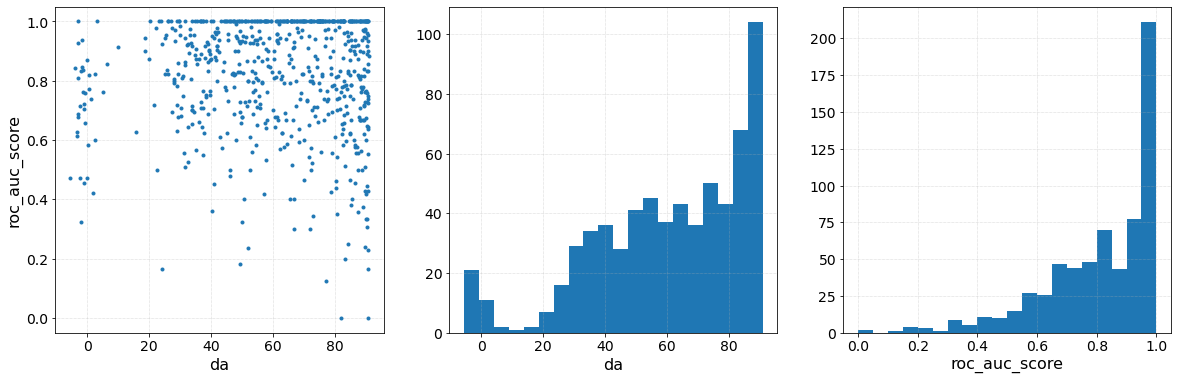

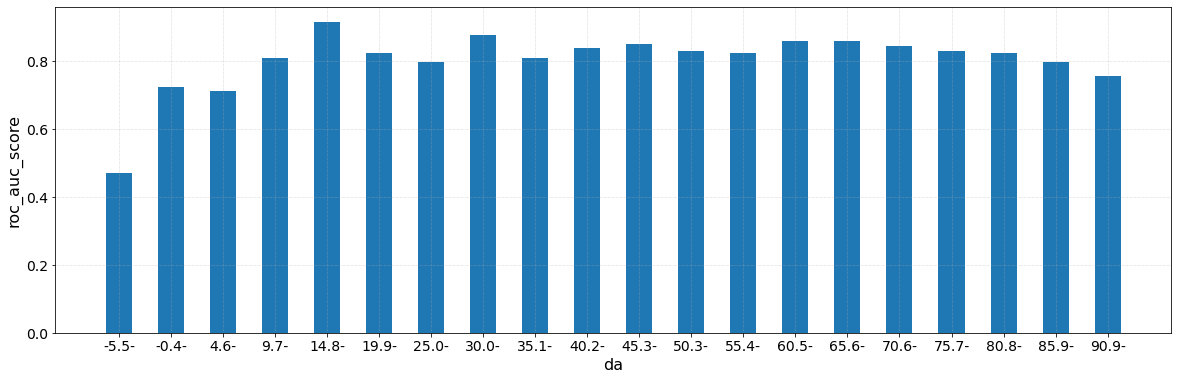

In [162]:
# plot predicted DA vs AUC
plot_da_vs_expl_metric(roc_auc_score, pred_scores, mt_word_tags, mt_explanations, mt_fp_mask, reduction='sum')

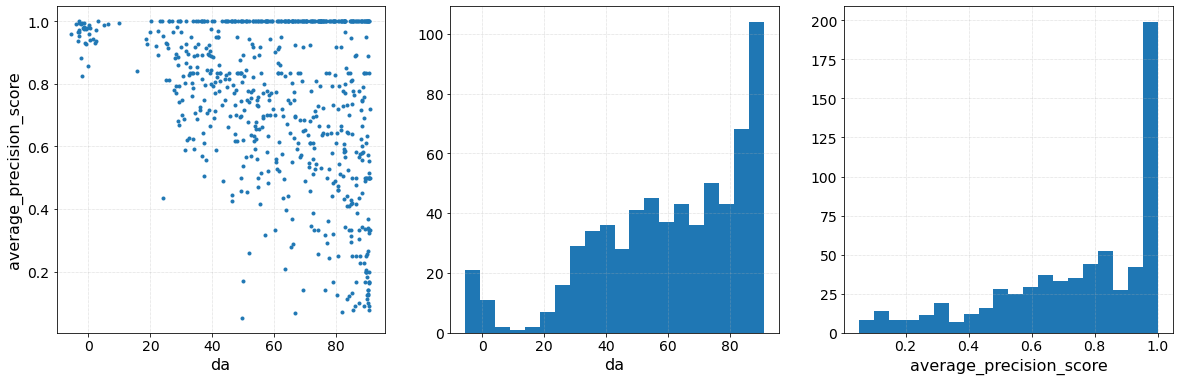

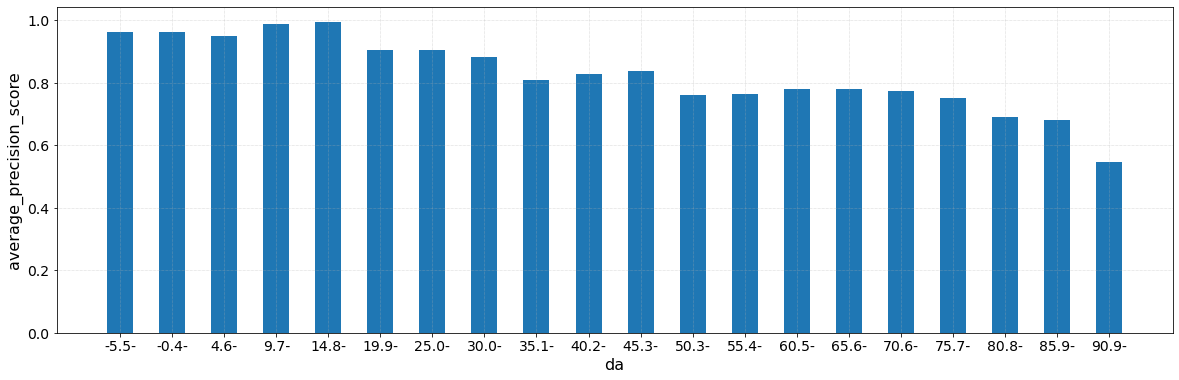

In [163]:
# plot predicted DA vs Average Precision
plot_da_vs_expl_metric(average_precision_score, pred_scores, mt_word_tags, mt_explanations, mt_fp_mask, reduction='sum')